# Baseline Analysis: Watching the Movie

**Input:** `W_movie.safetensors` from 01_baseline_movie.ipynb

**Questions:**
1. How does the dead token cloud radius evolve over time?
2. How does the dead token centroid move over time?

Just observation. No fimbulwinter analysis yet—that requires proper lattice-scale measurement.

---

*Jeffery Harrell & Alpha, December 1, 2025*

## Setup

In [21]:
import torch
from safetensors.torch import load_file
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


In [22]:
# === Parameters ===
MOVIE_PATH = "W_movie.safetensors"
PLOT_DPI = 150

In [23]:
def save_plot(fig, name, dpi=PLOT_DPI, output_dir="."):
    """Save a figure with our naming convention: {name}@{dpi}.png"""
    path = Path(output_dir) / f"{name}@{dpi}.png"
    fig.savefig(path, dpi=dpi, bbox_inches='tight', facecolor='white')
    print(f"Saved: {path}")
    return path

## Load Data

In [24]:
# Load the movie (safetensors mmaps by default)
data = load_file(MOVIE_PATH)

W = data["W"].to(torch.float32)  # [num_steps+1, vocab_size, d_model] - keep on CPU for now
losses = data["losses"].numpy()
dead_mask = data["dead_mask"]  # bool mask, keep on CPU

num_steps = W.shape[0] - 1
vocab_size = W.shape[1]
d_model = W.shape[2]
n_dead = dead_mask.sum().item()
n_live = vocab_size - n_dead

print(f"✓ Movie loaded: {num_steps:,} steps")
print(f"  W shape: [{vocab_size:,} × {d_model}]")
print(f"  Dead tokens: {n_dead:,}")
print(f"  Live tokens: {n_live:,}")

✓ Movie loaded: 10,000 steps
  W shape: [3,988 × 128]
  Dead tokens: 1,914
  Live tokens: 2,074


In [25]:
# Extract dead token trajectories (do indexing on CPU, then move to device)
with torch.no_grad():
    W_dead = W[:, dead_mask, :].to(device)  # [steps+1, n_dead, d_model]
    
print(f"✓ W_dead shape: {W_dead.shape}")

✓ W_dead shape: torch.Size([10001, 1914, 128])


## Dead Token Cloud Radius

In [26]:
with torch.no_grad():
    # Compute centroid at each timestep
    centroid_dead = W_dead.mean(dim=1)  # [steps+1, d_model]

    # Compute bounding radius: mean distance from centroid (L2 norm)
    centroid_dead_expanded = centroid_dead.unsqueeze(1)  # [steps+1, 1, d_model]
    dist_from_centroid = (W_dead - centroid_dead_expanded).norm(dim=2)  # [steps+1, n_dead]

    # Mean and max radius at each timestep
    mean_radius = dist_from_centroid.mean(dim=1).cpu().numpy()  # [steps+1]
    max_radius = dist_from_centroid.max(dim=1).values.cpu().numpy()  # [steps+1]

print(f"Initial mean radius: {mean_radius[0]:.6f}")
print(f"Final mean radius: {mean_radius[-1]:.6f}")
print(f"Compression ratio: {mean_radius[0] / mean_radius[-1]:.2f}x")

Initial mean radius: 0.225288
Final mean radius: 0.164906
Compression ratio: 1.37x


Saved: cloud_radius@150.png


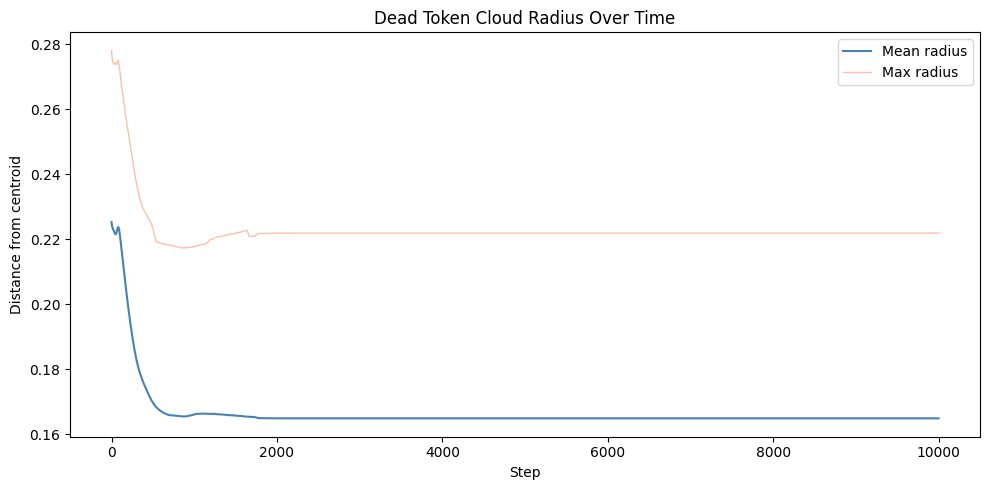

In [27]:
steps = np.arange(num_steps + 1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(steps, mean_radius, label='Mean radius', linewidth=1.5, color='steelblue')
ax.plot(steps, max_radius, label='Max radius', alpha=0.5, linewidth=1, color='coral')
ax.set_xlabel('Step')
ax.set_ylabel('Distance from centroid')
ax.set_title('Dead Token Cloud Radius Over Time')
ax.legend()
plt.tight_layout()
save_plot(fig, "cloud_radius")
plt.show()

## Dead Token Centroid Trajectory

In [28]:
with torch.no_grad():
    # How far has the dead centroid moved from its initial position?
    centroid_displacement = (centroid_dead - centroid_dead[0]).norm(dim=1).cpu().numpy()

    # Centroid norm over time
    centroid_norm = centroid_dead.norm(dim=1).cpu().numpy()

print(f"Initial centroid norm: {centroid_norm[0]:.6f}")
print(f"Final centroid norm: {centroid_norm[-1]:.6f}")
print(f"Total displacement from start: {centroid_displacement[-1]:.6f}")

Initial centroid norm: 0.005896
Final centroid norm: 0.387918
Total displacement from start: 0.387113


Saved: centroid_trajectory@150.png


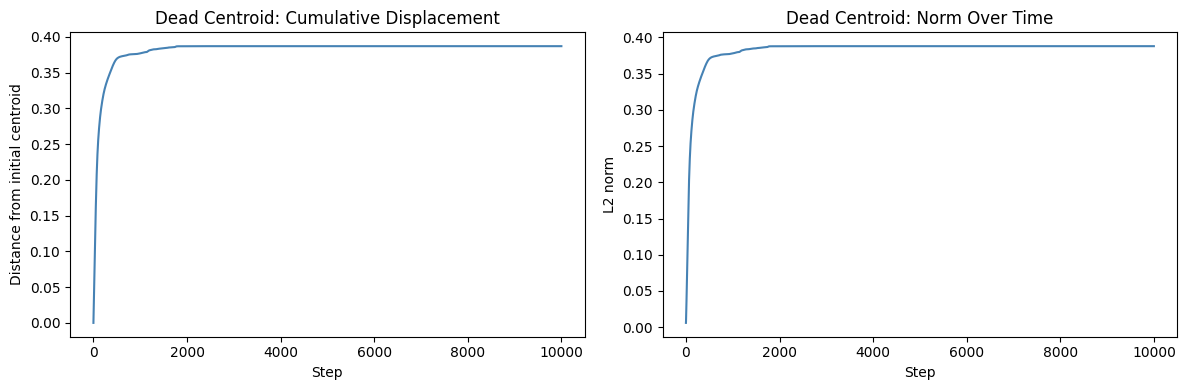

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Centroid displacement from initial position
ax = axes[0]
ax.plot(steps, centroid_displacement, linewidth=1.5, color='steelblue')
ax.set_xlabel('Step')
ax.set_ylabel('Distance from initial centroid')
ax.set_title('Dead Centroid: Cumulative Displacement')

# Centroid norm over time
ax = axes[1]
ax.plot(steps, centroid_norm, linewidth=1.5, color='steelblue')
ax.set_xlabel('Step')
ax.set_ylabel('L2 norm')
ax.set_title('Dead Centroid: Norm Over Time')

plt.tight_layout()
save_plot(fig, "centroid_trajectory")
plt.show()

## Summary

In [30]:
print("=" * 50)
print("BASELINE MOVIE SUMMARY")
print("=" * 50)
print(f"Steps: {num_steps:,}")
print(f"Dead tokens: {n_dead:,}")
print()
print("DEAD CLOUD RADIUS:")
print(f"  Initial (mean): {mean_radius[0]:.6f}")
print(f"  Final (mean): {mean_radius[-1]:.6f}")
print(f"  Compression: {mean_radius[0] / mean_radius[-1]:.2f}x")
print()
print("DEAD CENTROID:")
print(f"  Initial norm: {centroid_norm[0]:.6f}")
print(f"  Final norm: {centroid_norm[-1]:.6f}")
print(f"  Total displacement: {centroid_displacement[-1]:.6f}")

BASELINE MOVIE SUMMARY
Steps: 10,000
Dead tokens: 1,914

DEAD CLOUD RADIUS:
  Initial (mean): 0.225288
  Final (mean): 0.164906
  Compression: 1.37x

DEAD CENTROID:
  Initial norm: 0.005896
  Final norm: 0.387918
  Total displacement: 0.387113
